In [56]:
import xarray as xr
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

In [125]:
import os

def find_files_with_orbit_number(directory, orbit_number):
    matching_files = []

    # 确保轨道编号是字符串格式
    orbit_number_str = str(orbit_number).zfill(3)  # 填充到3位数

    # 遍历指定目录下的所有文件
    for filename in os.listdir(directory):
        if filename.endswith('.nc'):  # 确保文件是.nc格式
            # 检查文件名中的特定位置数字是否与周期编号匹配
            # print(filename[25:28])
            if filename[21:24] == orbit_number_str:
                matching_files.append(filename)

    return matching_files

# 使用示例
directory = r'C:\Users\yangleir\Downloads\swot\data\L3\21day'
orbit_number = 5
# orbit_number = calculate_orbit_number(412)
# 您要查找的周期编号
files = find_files_with_orbit_number(directory, orbit_number)
# 打印匹配的文件名
# 打印前5个文件
for file in files[:5]:
    print(file)

# 输出文件总数
print("文件总数:", len(files))
    

SWOT_L3_LR_SSH_Basic_005_001_20231012T163405_20231012T172531_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_002_20231012T172532_20231012T181659_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_003_20231012T181659_20231012T190825_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_004_20231012T190826_20231012T195952_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_005_20231012T195952_20231012T205119_v0.3.nc
文件总数: 549


In [126]:
# 文件路径
base_path = r'C:\Users\yangleir\Downloads\swot\data\L3\21day'
# files = sorted(os.listdir(base_path))  # 确保文件是按顺序排列的

SWOT_L3_LR_SSH_Basic_005_001_20231012T163405_20231012T172531_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_002_20231012T172532_20231012T181659_v0.3.nc


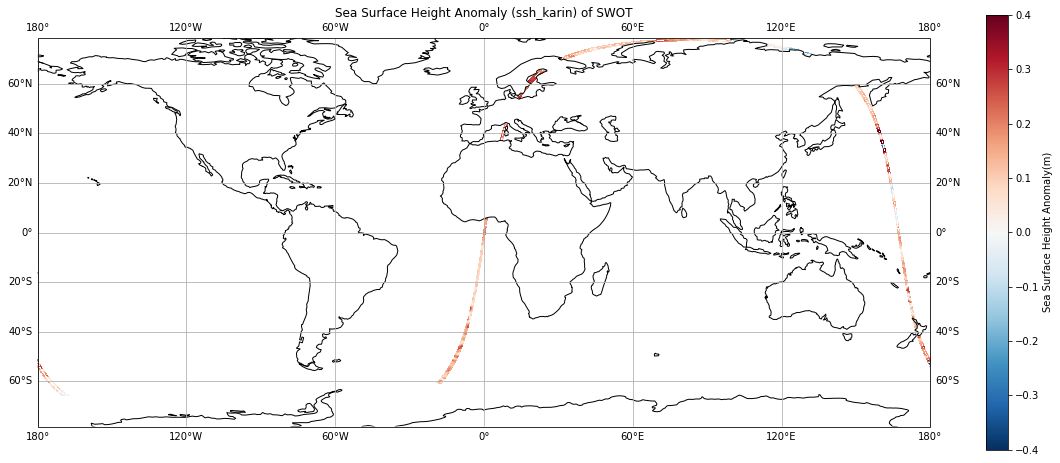

Wall time: 446 ms


In [128]:
%%time
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 初始化绘图
plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
vmin, vmax = -0.4, 0.4  # 假设的颜色条范围，根据数据进行调整

# 循环读取前50个文件
for file in files[0:2]:
    file_path = os.path.join(base_path, file)
    
    try:
        print(file)
        data = xr.open_dataset(file_path)
        
        # 提取 'ssha' 变量
        # ssh_karin = data['ssha']
        ssh_karin = data['ssha'].isel(num_lines=slice(None, None, 10), num_pixels=slice(None, None, 10))

        # 绘制海平面高度到地图上
        ssh_plot = plt.pcolormesh(ssh_karin.longitude, ssh_karin.latitude, ssh_karin, cmap='RdBu_r', shading='auto', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        data.close()  # 关闭文件，释放资源
    except (OSError, RuntimeError) as e:
        print(f"Skipping file {file} due to error: {e}")
        continue

plt.colorbar(ssh_plot, label='Sea Surface Height Anomaly(m)')
plt.title('Sea Surface Height Anomaly (ssh_karin) of SWOT')
plt.show()


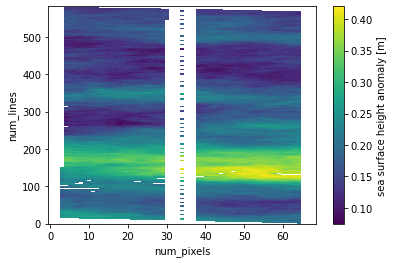

In [135]:
# 假设 data_array 是你的原始数据
ssh_karin = data['ssha']
latitude_filtered = ssh_karin.where((ssh_karin.latitude >= 30) & (ssh_karin.latitude <= 40), drop=True)
latitude_filtered.plot()

In [140]:
import xarray as xr
import numpy as np

def calculate_geostrophic_current(data_array, grid_spacing):
    """
    计算给定数据的地转流速度。

    参数:
    data_array (xarray.DataArray): 包含海面高度异常的数据数组。
    grid_spacing (float): 数据的网格间隔，单位为米。

    返回:
    ug (xarray.DataArray): 东向地转流速度。
    vg (xarray.DataArray): 北向地转流速度。
    """
    # 定义科氏参数 f
    Omega = 7.2921e-5  # 地球自转角速度(rad/s)
    # 计算每个格点的科氏参数 f
    f = 2 * Omega * np.sin(np.deg2rad(data_array.latitude))

    # 定义重力加速度 g
    g = 9.81  # m/s^2

    # 计算海面高度梯度
    gradient = np.gradient(data_array, grid_spacing, edge_order=2)  # 使用np.gradient求梯度，并提供网格间距
    dy, dx = xr.DataArray(gradient[0], dims=data_array.dims, coords=data_array.coords), xr.DataArray(gradient[1], dims=data_array.dims, coords=data_array.coords)

    # 计算地转流速度
    ug = -g / f * dy
    vg = g / f * dx

    # 设置名称属性
    ug.name = "Geostrophic current in the eastward direction (m/s)"
    vg.name = "Geostrophic current in the northward direction (m/s)"

    return ug, vg

# 示例使用
# ssh_karin 是一个示例的 xarray.DataArray，你需要替换成你的数据对象
ug, vg = calculate_geostrophic_current(latitude_filtered, 2000)
print("UG Maximum: ", ug.max(skipna=True).values)
print("VG Maximum: ", vg.max(skipna=True).values)



UG Maximum:  1.3583598327525503
VG Maximum:  1.2188815198169602


In [144]:
import xarray as xr
import numpy as np

def calculate_vorticity(u, v, dx, dy):
    """
    使用非规则坐标计算涡度。

    参数:
    u (xarray.DataArray): 东向速度分量，包含二维坐标。
    v (xarray.DataArray): 北向速度分量，包含二维坐标。
    dx (float): 东向网格点间的大致距离（单位：米）。
    dy (float): 北向网格点间的大致距离（单位：米）。

    返回:
    xarray.DataArray: 计算得到的涡度。
    """
    # 计算速度场的空间导数
    v_gradients = np.gradient(v.values)
    u_gradients = np.gradient(u.values)

    dvdx = v_gradients[1] / dx
    dudy = u_gradients[0] / dy

    # 创建涡度 DataArray
    vorticity_values = dvdx - dudy
    vorticity = xr.DataArray(vorticity_values, coords=v.coords, dims=v.dims)

    return vorticity

# 假设 ug 和 vg 是加载的东向和北向速度分量
# 假设数据集中 dx 和 dy 是网格间距，以米为单位
vorticity = calculate_vorticity(ug, vg, 2000, 2000)
print(vorticity)


<xarray.DataArray (num_lines: 582, num_pixels: 69)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    latitude   (num_lines, num_pixels) float64 40.28 40.27 40.27 ... 29.78 29.78
    longitude  (num_lines, num_pixels) float64 186.2 186.2 186.2 ... 187.4 187.4
Dimensions without coordinates: num_lines, num_pixels


In [159]:
import xarray as xr
import numpy as np

def calculate_kinetic_energy(u, v):
    """
    计算动能。

    参数:
    u (xarray.DataArray): 东向速度分量。
    v (xarray.DataArray): 北向速度分量。

    返回:
    xarray.DataArray: 动能场。
    """
    # 计算速度的平方和
    speed_squared = u**2 + v**2

    # 计算动能
    kinetic_energy = 0.5 * speed_squared

    # 保留速度分量的坐标和维度
    kinetic_energy = xr.DataArray(kinetic_energy, coords=u.coords, dims=u.dims)
    kinetic_energy.name = "Kinetic Energy"
    kinetic_energy.attrs['units'] = 'm^2/s^2'

    return kinetic_energy

# 示例使用
# 假设 `ug` 和 `vg` 是已加载的东向和北向速度分量的 DataArray
ke = calculate_kinetic_energy(ug, vg)
print(ke)


<xarray.DataArray 'Kinetic Energy' (num_lines: 1159, num_pixels: 69)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    latitude   (num_lines, num_pixels) float64 50.34 50.34 50.33 ... 29.78 29.78
    longitude  (num_lines, num_pixels) float64 182.6 182.5 182.5 ... 187.4 187.4
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    units:    m^2/s^2


In [183]:
def log_kinetic_energy(ke):
    """
    对动能进行对数变换。

    参数:
    ke (xarray.DataArray): 动能数据。

    返回:
    xarray.DataArray: 对数变换后的动能。
    """
    # 确保数据中没有负数或零（加上一个小的正数epsilon）
    epsilon = 1e-10
    log_ke = np.log(ke + epsilon)

    # 创建一个新的DataArray对象以保存对数动能值
    log_ke = xr.DataArray(log_ke, coords=ke.coords, dims=ke.dims)
    log_ke.name = "Log of Kinetic Energy"
    log_ke.attrs['units'] = 'log(m^2/s^2)'

    return log_ke

In [184]:
# 假设 `ug` 和 `vg` 是已加载的东向和北向速度分量的 DataArray
ke = calculate_kinetic_energy(ug, vg)
log_ke = log_kinetic_energy(ke)
print(log_ke)

<xarray.DataArray 'Log of Kinetic Energy' (num_lines: 1159, num_pixels: 69)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    latitude   (num_lines, num_pixels) float64 50.34 50.34 50.33 ... 29.78 29.78
    longitude  (num_lines, num_pixels) float64 1.325 1.298 1.271 ... 6.202 6.182
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    units:    log(m^2/s^2)


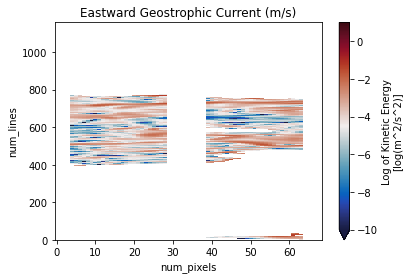

In [189]:
import matplotlib.pyplot as plt
import cmocean

# 计算总的流速
total_speed = np.sqrt(ug**2 + vg**2)

# 使用vmin和vmax参数设置颜色范围为-1到1
log_ke.plot(vmin=-10, vmax=1,cmap=cmocean.cm.balance)

plt.title('Eastward Geostrophic Current (m/s)')
plt.show()


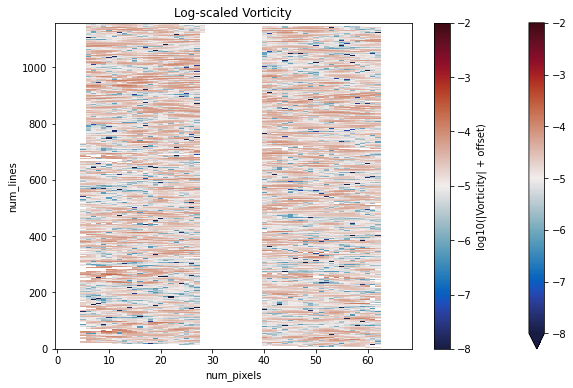

In [174]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean

def plot_log_vorticity(vorticity):
    """
    绘制涡度数据的对数尺度图。

    参数:
    vorticity (xarray.DataArray): 涡度数据。
    """
    # 确保没有负数或零值，因为我们将使用对数尺度
    # 偏移量应根据数据具体范围调整
    offset = 0

    # 应用对数变换
    log_vorticity = np.log10(np.abs(vorticity) + offset)

    # 绘制图像
    plt.figure(figsize=(10, 6))
    im = log_vorticity.plot(vmin=-8, vmax=-2, cmap=cmocean.cm.balance, add_colorbar=True)
    plt.colorbar(im, label='log10(|Vorticity| + offset)')
    plt.title('Log-scaled Vorticity')
    plt.show()

# 示例使用
# 假设 `vorticity` 是已加载的涡度数据
plot_log_vorticity(vorticity)


SWOT_L3_LR_SSH_Basic_005_001_20231012T163405_20231012T172531_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_015_20231013T043421_20231013T052547_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_029_20231013T163436_20231013T172603_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_040_20231014T020032_20231014T025158_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_050_20231014T103500_20231014T112627_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_060_20231014T190928_20231014T200055_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_070_20231015T034356_20231015T043523_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_081_20231015T130951_20231015T140118_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_093_20231015T232713_20231016T001840_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_103_20231016T080141_20231016T085308_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_113_20231016T163610_20231016T172736_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_123_20231017T011038_20231017T020205_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_133_20231017T094506_20231017T103632_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_143_20231017T181934_20231017T191101_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_154_20231

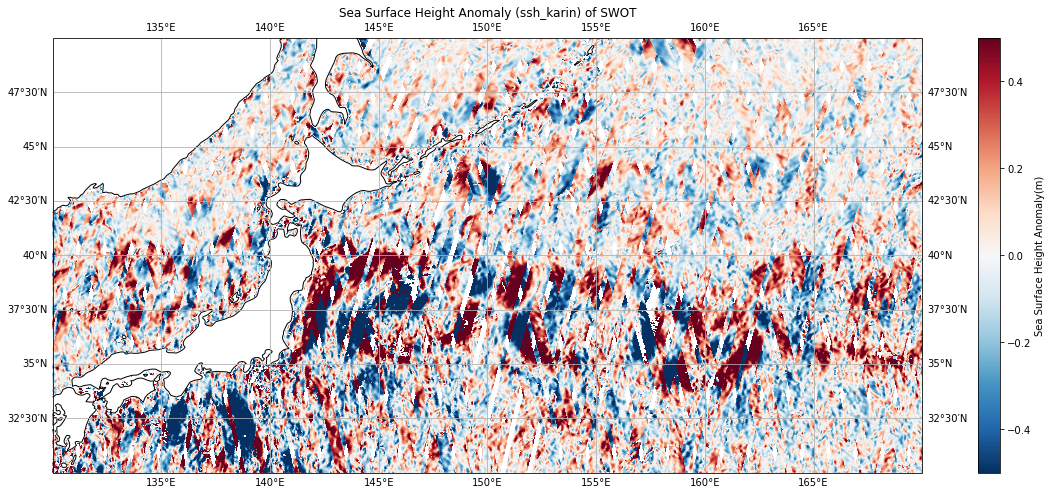

Wall time: 1min 31s


In [158]:
%%time
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 初始化绘图
plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# 定义黑潮区域的经纬度边界
lon_min, lon_max = 130, 170  # 东经120°到150°
lat_min, lat_max = 30, 50    # 北纬20°到40°
vmin, vmax = -0.5, 0.5  # 假设的颜色条范围，根据数据进行调整

# 设置地图显示的区域
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 文件路径
base_path = r'C:\Users\yangleir\Downloads\swot\data\L3\21day'
# files = sorted(os.listdir(base_path))  # 确保文件是按顺序排列的

# 初始化计数器
counter = 0
# 循环读取前100个文件
for file in files[0:]:
    file_path = os.path.join(base_path, file)
    
    try:
        
        data = xr.open_dataset(file_path)
        # 每10个文件打印一次文件名
        if counter % 10 == 0:
            print(file)
        # 更新计数器
        counter += 1
        # 提取 'ssha' 变量并进行抽稀
        ssh_karin = data['ssha_noiseless'].isel(num_lines=slice(None, None, 1), num_pixels=slice(None, None, 1))

        ssh_karin = ssh_karin.where(
            (ssh_karin.longitude >= 0) & (ssh_karin.longitude <= 360) &
            (ssh_karin.latitude >= lat_min) & (ssh_karin.latitude <= lat_max),
            drop=True
        )
        ug, vg = calculate_geostrophic_current(ssh_karin, 2000)
        # vorticity = calculate_vorticity(ug, vg, 2000, 2000)
        # ssh_plot = plt.pcolormesh(ug.longitude, ug.latitude, ug, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        ssh_plot = plt.pcolormesh(vg.longitude, vg.latitude, vg, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        # 绘制海平面高度到地图上
        # ssh_plot = plt.pcolormesh(ssh_karin.longitude, ssh_karin.latitude, ssh_karin, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        data.close()  # 关闭文件，释放资源
    except (OSError, RuntimeError) as e:
        print(f"Skipping file {file} due to error: {e}")
        continue

plt.colorbar(ssh_plot, label='Sea Surface Height Anomaly(m)')
plt.title('Sea Surface Height Anomaly (ssh_karin) of SWOT')
plt.show()


SWOT_L3_LR_SSH_Basic_005_001_20231012T163405_20231012T172531_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_015_20231013T043421_20231013T052547_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_029_20231013T163436_20231013T172603_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_040_20231014T020032_20231014T025158_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_050_20231014T103500_20231014T112627_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_060_20231014T190928_20231014T200055_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_070_20231015T034356_20231015T043523_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_081_20231015T130951_20231015T140118_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_093_20231015T232713_20231016T001840_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_103_20231016T080141_20231016T085308_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_113_20231016T163610_20231016T172736_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_123_20231017T011038_20231017T020205_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_133_20231017T094506_20231017T103632_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_143_20231017T181934_20231017T191101_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_154_20231

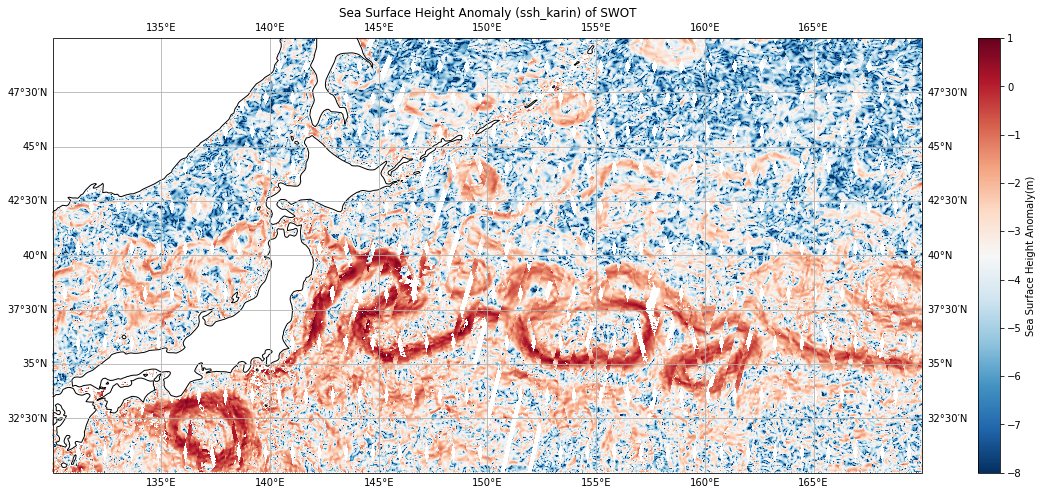

Wall time: 1min 31s


In [195]:
%%time
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 初始化绘图
plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# 定义黑潮区域的经纬度边界
lon_min, lon_max = 130, 170  # 东经120°到150°
lat_min, lat_max = 30, 50    # 北纬20°到40°
vmin, vmax = -8, 1  # 假设的颜色条范围，根据数据进行调整

# 设置地图显示的区域
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 文件路径
base_path = r'C:\Users\yangleir\Downloads\swot\data\L3\21day'
# files = sorted(os.listdir(base_path))  # 确保文件是按顺序排列的

# 初始化计数器
counter = 0
# 循环读取前100个文件
for file in files[0:]:
    file_path = os.path.join(base_path, file)
    
    try:
        
        data = xr.open_dataset(file_path)
        # 每10个文件打印一次文件名
        if counter % 10 == 0:
            print(file)
        # 更新计数器
        counter += 1
        # 提取 'ssha' 变量并进行抽稀
        ssh_karin = data['ssha_noiseless'].isel(num_lines=slice(None, None, 1), num_pixels=slice(None, None, 1))

        ssh_karin = ssh_karin.where(
            (ssh_karin.longitude >= 0) & (ssh_karin.longitude <= 360) &
            (ssh_karin.latitude >= lat_min) & (ssh_karin.latitude <= lat_max),
            drop=True
        )
        ug, vg = calculate_geostrophic_current(ssh_karin, 2000)
        # vorticity = calculate_vorticity(ug, vg, 2000, 2000)
        ke = calculate_kinetic_energy(ug, vg)
        log_ke = log_kinetic_energy(ke)
        # ssh_plot = plt.pcolormesh(ug.longitude, ug.latitude, ug, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        ssh_plot = plt.pcolormesh(log_ke.longitude, log_ke.latitude, log_ke, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        # 绘制海平面高度到地图上
        # ssh_plot = plt.pcolormesh(ssh_karin.longitude, ssh_karin.latitude, ssh_karin, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        data.close()  # 关闭文件，释放资源
    except (OSError, RuntimeError) as e:
        print(f"Skipping file {file} due to error: {e}")
        continue

plt.colorbar(ssh_plot, label='Sea Surface Height Anomaly(m)')
plt.title('Sea Surface Height Anomaly (ssh_karin) of SWOT')
plt.show()


SWOT_L3_LR_SSH_Basic_005_001_20231012T163405_20231012T172531_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_015_20231013T043421_20231013T052547_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_029_20231013T163436_20231013T172603_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_040_20231014T020032_20231014T025158_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_050_20231014T103500_20231014T112627_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_060_20231014T190928_20231014T200055_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_070_20231015T034356_20231015T043523_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_081_20231015T130951_20231015T140118_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_093_20231015T232713_20231016T001840_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_103_20231016T080141_20231016T085308_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_113_20231016T163610_20231016T172736_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_123_20231017T011038_20231017T020205_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_133_20231017T094506_20231017T103632_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_143_20231017T181934_20231017T191101_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_154_20231

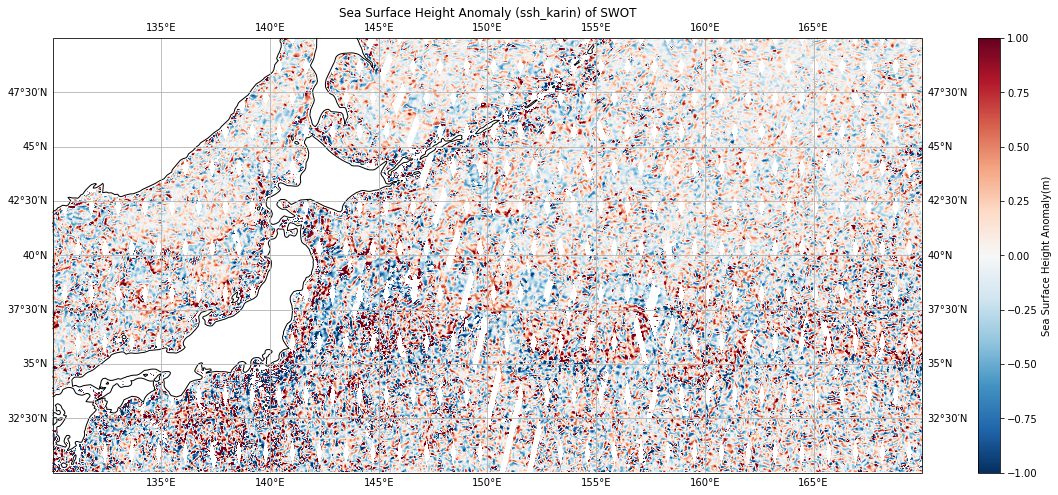

Wall time: 1min 29s


In [180]:
%%time
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 初始化绘图
plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# 定义黑潮区域的经纬度边界
lon_min, lon_max = 130, 170  # 东经120°到150°
lat_min, lat_max = 30, 50    # 北纬20°到40°
vmin, vmax = -1, 1  # 假设的颜色条范围，根据数据进行调整

# 设置地图显示的区域
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 文件路径
base_path = r'C:\Users\yangleir\Downloads\swot\data\L3\21day'
# files = sorted(os.listdir(base_path))  # 确保文件是按顺序排列的

# 初始化计数器
counter = 0
# 循环读取前100个文件
for file in files[0:]:
    file_path = os.path.join(base_path, file)
    
    try:
        
        data = xr.open_dataset(file_path)
        # 每10个文件打印一次文件名
        if counter % 10 == 0:
            print(file)
        # 更新计数器
        counter += 1
        # 提取 'ssha' 变量并进行抽稀
        ssh_karin = data['ssha_noiseless'].isel(num_lines=slice(None, None, 1), num_pixels=slice(None, None, 1))

        ssh_karin = ssh_karin.where(
            (ssh_karin.longitude >= 0) & (ssh_karin.longitude <= 360) &
            (ssh_karin.latitude >= lat_min) & (ssh_karin.latitude <= lat_max),
            drop=True
        )
        ug, vg = calculate_geostrophic_current(ssh_karin, 2000)
        vorticity = calculate_vorticity(ug, vg, 2000, 2000) * 1e4
        ssh_plot = plt.pcolormesh(vorticity.longitude, vorticity.latitude, vorticity, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        # 绘制海平面高度到地图上
        # ssh_plot = plt.pcolormesh(ssh_karin.longitude, ssh_karin.latitude, ssh_karin, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        data.close()  # 关闭文件，释放资源
    except (OSError, RuntimeError) as e:
        print(f"Skipping file {file} due to error: {e}")
        continue

plt.colorbar(ssh_plot, label='Sea Surface Height Anomaly(m)')
plt.title('Sea Surface Height Anomaly (ssh_karin) of SWOT')
plt.show()


SWOT_L3_LR_SSH_Basic_005_001_20231012T163405_20231012T172531_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_015_20231013T043421_20231013T052547_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_029_20231013T163436_20231013T172603_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_040_20231014T020032_20231014T025158_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_050_20231014T103500_20231014T112627_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_060_20231014T190928_20231014T200055_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_070_20231015T034356_20231015T043523_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_081_20231015T130951_20231015T140118_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_093_20231015T232713_20231016T001840_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_103_20231016T080141_20231016T085308_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_113_20231016T163610_20231016T172736_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_123_20231017T011038_20231017T020205_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_133_20231017T094506_20231017T103632_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_143_20231017T181934_20231017T191101_v0.3.nc
SWOT_L3_LR_SSH_Basic_005_154_20231

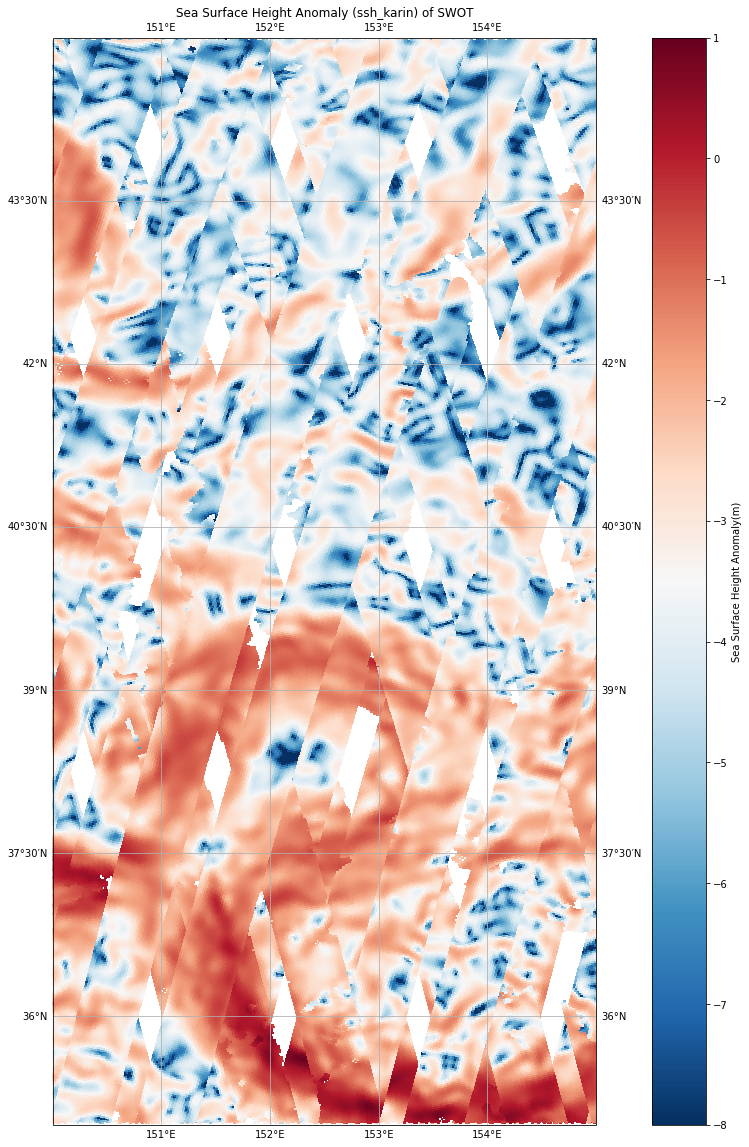

Wall time: 1min 10s


In [197]:
%%time
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 初始化绘图
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# 定义黑潮区域的经纬度边界
lon_min, lon_max = 150, 155  # 东经120°到150°
lat_min, lat_max = 35, 45   # 北纬20°到40°
vmin, vmax = -8, 1  # 假设的颜色条范围，根据数据进行调整

# 设置地图显示的区域
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 文件路径
base_path = r'C:\Users\yangleir\Downloads\swot\data\L3\21day'
# files = sorted(os.listdir(base_path))  # 确保文件是按顺序排列的

# 初始化计数器
counter = 0
# 循环读取前100个文件
for file in files[0:]:
    file_path = os.path.join(base_path, file)
    
    try:
        
        data = xr.open_dataset(file_path)
        # 每10个文件打印一次文件名
        if counter % 10 == 0:
            print(file)
        # 更新计数器
        counter += 1
        # 提取 'ssha' 变量并进行抽稀
        ssh_karin = data['ssha_noiseless'].isel(num_lines=slice(None, None, 1), num_pixels=slice(None, None, 1))

        ssh_karin = ssh_karin.where(
            (ssh_karin.longitude >= 0) & (ssh_karin.longitude <= 360) &
            (ssh_karin.latitude >= lat_min) & (ssh_karin.latitude <= lat_max),
            drop=True
        )
        ug, vg = calculate_geostrophic_current(ssh_karin, 2000)
        # vorticity = calculate_vorticity(ug, vg, 2000, 2000)
        ke = calculate_kinetic_energy(ug, vg)
        log_ke = log_kinetic_energy(ke)
        # ssh_plot = plt.pcolormesh(ug.longitude, ug.latitude, ug, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        ssh_plot = plt.pcolormesh(log_ke.longitude, log_ke.latitude, log_ke, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        # 绘制海平面高度到地图上
        # ssh_plot = plt.pcolormesh(ssh_karin.longitude, ssh_karin.latitude, ssh_karin, cmap='RdBu_r', shading='auto',vmin=vmin, vmax=vmax,  transform=ccrs.PlateCarree())
        data.close()  # 关闭文件，释放资源
    except (OSError, RuntimeError) as e:
        print(f"Skipping file {file} due to error: {e}")
        continue

plt.colorbar(ssh_plot, label='Sea Surface Height Anomaly(m)')
plt.title('Sea Surface Height Anomaly (ssh_karin) of SWOT')
plt.show()
